
# Climates like Flagstaff
The purpose of this analysis is to find climates like Flagstaff in other parts of the globe, preferably where the architecture isn't the result of recent colonization, and maybe also where the indigenous group is genetically similar to myself.

In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

%run ../load_magic/storage.py

s = Storage()


----
# Get the NOAA data

In [3]:

# Download the GNU zip file
from os.path import exists
import requests

gz_folder = '../saves/gz'
url = 'https://www.ncei.noaa.gov/data/global-summary-of-the-year/archive/gsoy-latest.tar.gz'
source_filename = url.split('/')[-1]
source_filepath = os.path.join(gz_folder, source_filename)
if not exists(source_filepath):
    os.makedirs(name=gz_folder, exist_ok=True)
    response = requests.get(url)
    with open(source_filepath, 'wb') as ibw:
        ibw.write(response.content)

In [4]:

# Write the tarball
import gzip

dest_filename = '.'.join(source_filename.split('.')[:-1])
tar_folder = '../saves/tar'
dest_filepath = os.path.join(tar_folder, dest_filename)
if not exists(dest_filepath):
    os.makedirs(name=tar_folder, exist_ok=True)
    with gzip.open(source_filepath, 'rb') as s_file, open(dest_filepath, 'wb') as d_file:
        while True:
            block = s_file.read(65_536)
            if not block:
                break
            else:
                d_file.write(block)

In [5]:

# Extract the CSVs
import tarfile

dest_folder = os.path.join(s.data_csv_folder, 'gsoy-latest')
if not exists(os.path.join(dest_folder, 'ACW00011647.csv')):
    os.makedirs(name=dest_folder, exist_ok=True)
    tar = tarfile.open(dest_filepath)
    tar.extractall(path=dest_folder)
    tar.close()

In [6]:

# Aggregate the CSVs and store them as a pickle and as a CSV
from tqdm.notebook import tqdm
tqdm.pandas()

if s.pickle_exists('climates_df'):
    climates_df = s.load_object('climates_df')
else:
    climates_df = pd.DataFrame([], columns=['csv_name'])
    csv_folder = os.path.join(s.data_csv_folder, 'gsoy-latest')
    csvs_list = [fn for fn in os.listdir(csv_folder) if fn.endswith('.csv')]
    for csv_name in tqdm(csvs_list):
        csv_path = os.path.join(csv_folder, csv_name)
        df = pd.read_csv(os.path.abspath(csv_path), encoding=s.encoding_type)
        df['csv_name'] = csv_name
        climates_df = pd.concat([climates_df, df], axis='index', ignore_index=True)
    s.store_objects(climates_df=climates_df, verbose=True)
    s.save_dataframes(climates_df=climates_df)


----
# Add Distance to Flagstaff column

In [7]:

# Add column for distanced to Flagstaff, AZ, USA
# Latitude and longitude coordinates are: 35.198284, -111.651299
import math
import numpy as np
from geopy.distance import distance

if 'distance_to_flagstaff' not in climates_df.columns:
    flagstaff_az = (-35.198284, 111.651299)
    def f(row_series):
        distance_to_flagstaff = np.nan
        latitude = row_series.LATITUDE
        longitude = row_series.LONGITUDE
        if (str(latitude) != 'nan') and (str(longitude) != 'nan'):
            lat_lon_tuple = (latitude, longitude)
            distance_to_flagstaff = distance(flagstaff_az, lat_lon_tuple).km

        return distance_to_flagstaff
    climates_df['distance_to_flagstaff'] = climates_df.progress_apply(f, axis='columns')
    s.store_objects(climates_df=climates_df, verbose=True)
    s.save_dataframes(climates_df=climates_df)

In [22]:

# Figure out which observations we know for sure are the same climate as Flagstaff
def f(x):
    
    return 'flagstaff' in str(x).lower()
mask_series = climates_df.NAME.map(f)
columns_list = ['distance_to_flagstaff', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']
climates_df[mask_series][columns_list].sort_values('distance_to_flagstaff').head(200).tail(20)

,distance_to_flagstaff,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
1635387,0.113344,US1AZCN0002,"FLAGSTAFF 7.8 SSW, AZ US",35.093850,-111.695350,2078.7
1635385,0.113344,US1AZCN0002,"FLAGSTAFF 7.8 SSW, AZ US",35.093850,-111.695350,2078.7
1635384,0.113344,US1AZCN0002,"FLAGSTAFF 7.8 SSW, AZ US",35.093850,-111.695350,2078.7
1635383,0.113344,US1AZCN0002,"FLAGSTAFF 7.8 SSW, AZ US",35.093850,-111.695350,2078.7
1635389,0.113344,US1AZCN0002,"FLAGSTAFF 7.8 SSW, AZ US",35.093850,-111.695350,2078.7
1635426,0.130167,US1AZCN0092,"FLAGSTAFF 8.2 NE, AZ US",35.268021,-111.541389,2041.9
1635425,0.130167,US1AZCN0092,"FLAGSTAFF 8.2 NE, AZ US",35.268021,-111.541389,2041.9
1635433,0.147351,US1AZCN0140,"FLAGSTAFF 9.8 NNE, AZ US",35.309071,-111.554146,2088.5
1635434,0.147351,US1AZCN0140,"FLAGSTAFF 9.8 NNE, AZ US",35.309071,-111.554146,2088.5
1635435,0.185256,US1AZCN0154,"FLAGSTAFF 10.5 E, AZ US",35.217705,-111.467064,1967.5


In [38]:

# Check observations close to Flagstaff without being explicitly named
def f(x):
    
    return 'flagstaff' in str(x).lower()
mask_series = (climates_df.distance_to_flagstaff < 0.2) & ~climates_df.NAME.map(f)
columns_list = ['distance_to_flagstaff', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']
climates_df[mask_series][columns_list].sort_values('distance_to_flagstaff')

,distance_to_flagstaff,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
2418721,0.114066,USS0011P02S,"FORT VALLEY, AZ US",35.2700,-111.7400,2240.3
2418733,0.114066,USS0011P02S,"FORT VALLEY, AZ US",35.2700,-111.7400,2240.3
2418732,0.114066,USS0011P02S,"FORT VALLEY, AZ US",35.2700,-111.7400,2240.3
2418731,0.114066,USS0011P02S,"FORT VALLEY, AZ US",35.2700,-111.7400,2240.3
2418730,0.114066,USS0011P02S,"FORT VALLEY, AZ US",35.2700,-111.7400,2240.3
...,...,...,...,...,...,...
1695078,0.173757,USC00020678,"BELLEMONT WEATHER FORECAST OFFICE, AZ US",35.2302,-111.8221,2179.9
1695079,0.173757,USC00020678,"BELLEMONT WEATHER FORECAST OFFICE, AZ US",35.2302,-111.8221,2179.9
1695080,0.173757,USC00020678,"BELLEMONT WEATHER FORECAST OFFICE, AZ US",35.2302,-111.8221,2179.9
1695070,0.173757,USC00020678,"BELLEMONT WEATHER FORECAST OFFICE, AZ US",35.2302,-111.8221,2179.9



# Use Random Forest to get the Features that are important to being nearby Flagstaff

In [61]:

# Get list of stations nearby Flagstaff
climates_df = climates_df.reset_index(drop=True)
nearby_list = climates_df[climates_df.distance_to_flagstaff < 0.2].index.tolist()

In [39]:

# Get numeric columns
%run ../load_magic/dataframes.py

get_column_descriptions_df = get_column_descriptions(climates_df.sample(min(5_000, climates_df.shape[0])))
mask_series = ~get_column_descriptions_df.column_name.isin(['distance_to_flagstaff', 'LONGITUDE', 'LATITUDE', 'elevation_diff', 'DATE', 'index'])
mask_series = mask_series & get_column_descriptions_df.dtype.isin(['int64', 'float64']) & (get_column_descriptions_df.count_uniques > 2)
df = get_column_descriptions_df[mask_series].sort_values(['count_uniques'], ascending=[False])
numeric_columns_list = df.column_name.tolist()
df

,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates,min_value,max_value,only_integers
15,PRCP,float64,465,3925,1,True,0.0,9281.6,False
4,ELEVATION,float64,130,2046,32,True,-55.8,4771.0,False
27,HDSD,float64,3391,1563,34,True,0.0,12295.9,False
29,HTDD,float64,3392,1562,34,True,0.0,12295.9,False
17,CDSD,float64,3390,1422,56,True,0.0,3997.4,False
...,...,...,...,...,...,...,...,...,...
47,PSUN,float64,4997,4,0,True,52.9,75.1,False
45,MNPN,float64,4997,4,0,True,18.11,23.2,False
59,WSFM,float64,4998,3,0,True,13.9,24.1,False
53,WDFM,float64,4998,3,0,True,135.0,225.0,False


In [55]:

from sklearn.ensemble import RandomForestClassifier

rfclf = RandomForestClassifier()
X = climates_df[numeric_columns_list].fillna(0).values
y = climates_df.index.isin(nearby_list)
rfclf.fit(X, y)

RandomForestClassifier()

In [129]:

# Show columns important for determining if like Flagstaff
# Warning: impurity-based feature importances can be misleading for high cardinality features (many unique values)
feature_importances_tuples_list = sorted([(cn, ci) for cn, ci in zip(numeric_columns_list, rfclf.feature_importances_) if ci > 0.0],
                                         key=lambda x: x[1], reverse=True)[:6]
print(feature_importances_tuples_list)

[('ELEVATION', 0.23153980093427998), ('PRCP', 0.04434836212649677), ('EMXP', 0.03908307179076151), ('DT32', 0.03347134333827441), ('HTDD', 0.033167256802250696), ('HDSD', 0.03224461979784765)]


In [ ]:

from sklearn.inspection import permutation_importance

result = permutation_importance(rfclf, X, y, n_repeats=10)

In [132]:

feature_importances_tuples_list = sorted([(cn, ci) for cn, ci in zip(numeric_columns_list, result.importances_mean)], key=lambda x: x[1], reverse=True)[:6]
print(feature_importances_tuples_list)

[('ELEVATION', 0.00017943059840985764), ('DT32', 8.274982566419675e-05), ('TMAX', 6.770440281618217e-05), ('DP01', 3.446914335029083e-05), ('TMIN', 3.251881075887475e-05), ('PRCP', 3.068788628531882e-05)]



# Try to find some Clustering Algorithm that naturally bunches those climates like Flagstaff

In [70]:

from functools import partial
from sklearn import manifold
from collections import OrderedDict
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import FastICA

# Set-up manifold methods
n_neighbors = 10
n_components = 2
LLE = partial(
    manifold.LocallyLinearEmbedding,
    n_neighbors=n_neighbors,
    n_components=n_components,
    eigen_solver='auto',
)

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa', eigen_solver='dense')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(
    n_components=n_components, n_neighbors=n_neighbors
)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
methods['Incremental PCA'] = IncrementalPCA(n_components=n_components, batch_size=10)
methods['PCA'] = PCA(n_components=n_components)
methods['Kernel PCA'] = KernelPCA(kernel='rbf', fit_inverse_transform=True, gamma=10)
methods['Truncated SVD'] = TruncatedSVD(n_components=n_components)
methods['Factor Analysis'] = FactorAnalysis(n_components=n_components)
methods['Fast ICA'] = FastICA(n_components=n_components)

C:\Users\daveb\AppData\Local\Temp\ipykernel_16892\1420962170.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(climates_df[~mask_series][columns_list].sample(sample_size - df.shape[0]))


Error in determining null-space with ARPACK. Error message: 'Factor is exactly singular'. Note that eigen_solver='arpack' can fail when the weight matrix is singular or otherwise ill-behaved. In that case, eigen_solver='dense' is recommended. See online documentation for more information.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initializatio

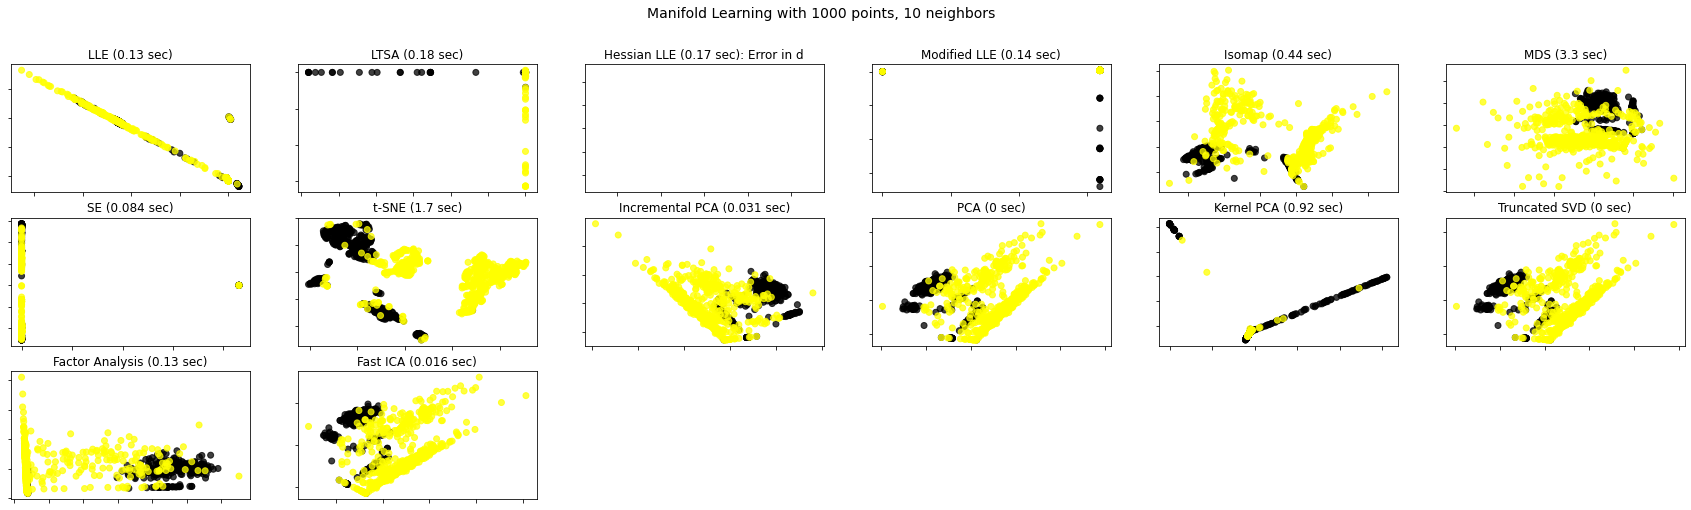

In [133]:

import matplotlib.pyplot as plt
from time import time
from matplotlib.ticker import NullFormatter

columns_list = [fi_tuple[0] for fi_tuple in feature_importances_tuples_list]
sample_size = 1_000
mask_series = climates_df.index.isin(nearby_list)
df = climates_df[mask_series][columns_list]
if df.shape[0] < sample_size:
    df = df.append(climates_df[~mask_series][columns_list].sample(sample_size - df.shape[0]))
else:
    df = df.sample(sample_size)
colors_list = []
for idx in df.index:
    if idx in nearby_list:
        colors_list.append('black')
    else:
        colors_list.append('yellow')
X1 = df.fillna(0).values
scaler = preprocessing.StandardScaler().fit(X1)
X1_scaled = scaler.transform(X1)

# Create figure
fig = plt.figure(figsize=(30, 8))
fig.suptitle(
    'Manifold Learning with %i points, %i neighbors' % (sample_size, n_neighbors), fontsize=14
)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    ax = fig.add_subplot(3, 6, 1 + i)
    t0 = time()
    try:
        y1 = method.fit_transform(X1_scaled)
        t1 = time()
        ax.set_title('%s (%.2g sec)' % (label, t1 - t0))
        ax.scatter(y1[:, 0], y1[:, 1], c=colors_list, cmap=plt.cm.Spectral, alpha=0.75)
    except (SystemError, RuntimeError, ValueError) as e:
        t1 = time()
        ax.set_title('%s (%.2g sec): %s' % (label, t1 - t0, str(e).strip()[:10]))
        print(str(e).strip())
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

In [82]:

s.store_objects(numeric_columns_list=numeric_columns_list, rfclf=rfclf)

Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\notebooks\saves\pkl\numeric_columns_list.pkl
Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\notebooks\saves\pkl\rfclf.pkl


In [83]:

if 'is_like_flagstaff' not in climates_df.columns:
    tqdm.pandas()
    def f(row_series):

        # Reshape your data using array.reshape(1, -1) if your data contains a single sample
        X = row_series[numeric_columns_list].fillna(0).values.reshape(1, -1)

        return rfclf.predict(X)[0]
    climates_df['is_like_flagstaff'] = climates_df.progress_apply(f, axis='columns')


# Try to bound a subselection by the minimum and maximum of the important features

In [134]:

columns_list = [fi_tuple[0] for fi_tuple in feature_importances_tuples_list]
mask_series = climates_df.index.isin(nearby_list)
df = climates_df[mask_series][columns_list].describe()
mask_series = True
for column_name in columns_list:
    mask_series = mask_series & (climates_df[column_name] >= df.loc['min', column_name]) & (climates_df[column_name] <= df.loc['max', column_name])
climates_df['is_like_flagstaff'] = False
climates_df.loc[mask_series, 'is_like_flagstaff'] = True
columns_list = ['distance_to_flagstaff', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE'] + columns_list
climates_df[mask_series][columns_list].sample(20).sort_values('distance_to_flagstaff')

,distance_to_flagstaff,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DT32,TMAX,DP01,TMIN,PRCP
2271549,2.390834,USC00420086,"ALTON, UT US",37.44020,-112.48190,2163.5,191.0,14.67,84.0,0.00,403.0
1705218,2.495647,USC00027440,"ST MICHAELS 6 WNW, AZ US",35.66667,-109.20000,2329.9,193.0,16.70,44.0,-0.69,339.7
2058951,2.904440,USC00293626,"GOWER, NM US",35.33333,-108.75000,2226.9,199.0,17.70,78.0,0.30,324.2
1766795,4.306391,USC00052432,"DURANGO, CO US",37.28333,-107.88333,2011.7,189.0,17.55,113.0,0.51,656.8
2059493,4.413382,USC00293951,"HERMOSA, NM US",33.16667,-107.73333,2011.7,189.0,17.05,50.0,0.37,237.0
2055757,4.748235,USC00292241,"CUBA, NM US",35.99510,-106.97040,2105.6,195.0,17.34,49.0,-0.30,349.9
2409790,4.887502,USS0006P10S,"SENORITA DIVIDE NUMBER 2, NM US",36.00000,-106.83000,2621.3,209.0,14.52,115.0,-3.06,892.7
2419607,5.274671,USS0012J06S,"ROCKY BASIN SETTLEME, UT US",40.44000,-112.24000,2712.7,193.0,9.80,107.0,-0.60,961.7
2433782,5.370136,USW00003087,"SANTA FE 20 WNW, NM US",35.82450,-106.31780,2212.2,142.0,15.88,79.0,3.16,458.5
2419633,5.377859,USS0012J07S,"MINING FORK, UT US",40.49000,-112.61000,2505.8,147.0,10.69,101.0,2.26,738.1



# Add a Wikipedia URL Column

In [94]:

import wikipedia
import numpy as np
from wikipedia.exceptions import (PageError, DisambiguationError, WikipediaException)
from IPython.display import clear_output
from time import sleep

if ('wikipedia_url' not in climates_df.columns) or climates_df.wikipedia_url.isnull().all():
    mask_series = climates_df.is_like_flagstaff & climates_df.wikipedia_url.isnull()
    for row_index, row_series in climates_df[mask_series].iterrows():
        latitude = row_series.LATITUDE
        longitude = row_series.LONGITUDE
        titles_list = wikipedia.geosearch(latitude=latitude, longitude=longitude, radius=10_000)
        if titles_list:
            try:
                wikipedia_url = wikipedia.page(title=titles_list[0]).url
                climates_df.loc[row_index, 'wikipedia_url'] = wikipedia_url
                clear_output(wait=True)
                print(f'{row_series.NAME}: {wikipedia_url}')
            except (PageError, DisambiguationError) as e:
                clear_output(wait=True)
                print(f'{row_series.NAME}: {str(e).strip()}')
            except (WikipediaException) as e:
                clear_output(wait=True)
                print(f'{row_series.NAME}: {str(e).strip()}')
                sleep(60)
    s.store_objects(climates_df=climates_df, verbose=True)
    s.save_dataframes(climates_df=climates_df)

In [141]:

wikipedia_url = np.nan
mask_series = climates_df.NAME.isin(['BLIND PARK, SD US'])
climates_df.loc[mask_series, 'wikipedia_url'] = wikipedia_url

# wikipedia_url = 'https://en.wikipedia.org/wiki/Summer_Lake_%28Oregon%29'
# mask_series = climates_df.NAME.isin(['SUMMER RIM, OR US'])
# climates_df.loc[mask_series, 'wikipedia_url'] = wikipedia_url

s.store_objects(climates_df=climates_df, verbose=True)
s.save_dataframes(climates_df=climates_df, verbose=True)

Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\notebooks\saves\pkl\climates_df.pkl
Saving to C:\Users\daveb\OneDrive\Documents\GitHub\notebooks\saves\csv\climates_df.csv


In [142]:

columns_list = ['distance_to_flagstaff', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'wikipedia_url'] + [fi_tuple[0] for fi_tuple in feature_importances_tuples_list]
mask_series = climates_df.is_like_flagstaff & ~climates_df.wikipedia_url.isnull()
df = climates_df[mask_series][columns_list].sort_values('NAME')
mask_series = (df.NAME.shift(-1) != df.NAME)
df[mask_series].sort_values('distance_to_flagstaff').tail(20)

,distance_to_flagstaff,STATION,NAME,LATITUDE,LONGITUDE,wikipedia_url,ELEVATION,DT32,TMAX,DP01,TMIN,PRCP
2415897,11.388101,USS0011C02S,"PICKFOOT CREEK, MT US",46.58000,-111.27000,https://en.wikipedia.org/wiki/Algiers_station,2026.9,186.0,9.83,124.0,0.01,775.5
1236189,11.730972,MXN00010121,"LOS ALTARES, MX",24.98330,-105.88330,https://en.wikipedia.org/wiki/Algiers_station,2489.9,179.0,19.30,119.0,0.78,841.3
2413716,11.755748,USS0010C23S,"STRINGER CREEK, MT US",46.93000,-110.90000,https://en.wikipedia.org/wiki/Algiers_station,1996.4,213.0,11.63,111.0,-2.80,663.5
2406321,11.758721,USS0003E03S,"BLIND PARK, SD US",44.11000,-103.98000,https://en.wikipedia.org/wiki/Algiers_station,2100.1,199.0,11.06,103.0,-2.17,661.2
2428077,11.831081,USS0020G02S,"SUMMER RIM, OR US",42.70000,-120.80000,https://en.wikipedia.org/wiki/Summer_Lake_%28O...,2158.0,179.0,10.73,82.0,1.61,379.4
2154443,13.006327,USC00351946,"CRATER LAKE NPS HQ, OR US",42.89765,-122.13387,https://en.wikipedia.org/wiki/Crater_Lake_Nati...,1976.6,244.0,10.24,115.0,-2.31,1181.9
1234162,13.024904,MXN00010044,"LLANO GRANDE CFE, MX",23.88330,-105.20000,"https://en.wikipedia.org/wiki/Llano_Grande,_Me...",2584.7,154.0,18.94,95.0,2.30,911.6
1233611,13.030658,MXN00010025,"EL SALTO SMN, MX",23.78330,-105.36670,"https://en.wikipedia.org/wiki/El_Salto,_Durango",2559.7,179.0,18.90,118.0,0.52,1090.0
1329155,14.187472,MXN00032093,"EL ARENAL, MX",23.63330,-103.43330,"https://en.wikipedia.org/wiki/El_Arenal,_Jalisco",2218.9,168.0,18.35,27.0,0.24,222.7
1260964,19.500121,MXN00015066,"PALIZADA, MX",19.50000,-100.08330,https://en.wikipedia.org/wiki/Palizada,2635.0,162.0,19.27,131.0,1.68,1005.8



<img src="https://upload.wikimedia.org/wikipedia/commons/3/3f/Sierra_Madre.jpg" width="100%" />


# Make a Bounding Box around Europe

In [144]:

westernmost_longitude = -9.500556
easternmost_longitude = 66.618056
northernmost_latitude = 71.133889
southernmost_latitude = 36
mask_series = climates_df.is_like_flagstaff
mask_series = mask_series & (climates_df.LATITUDE <= northernmost_latitude) & (climates_df.LATITUDE >= southernmost_latitude)
mask_series = mask_series & (climates_df.LONGITUDE >= westernmost_longitude) & (climates_df.LONGITUDE <= easternmost_longitude)
columns_list = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'distance_to_flagstaff', 'wikipedia_url']
df = climates_df[mask_series][columns_list]
df = df.sort_values('distance_to_flagstaff', ascending=False)
df.loc[df.NAME.shift(-1) != df.NAME].head(20)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,distance_to_flagstaff,wikipedia_url
1544786,SPE00156387,"NURIA, SP",42.3817,2.1553,1971.0,114.033080,https://en.wikipedia.org/wiki/Vall_de_N%C3%BAria
1544714,SPE00156333,"MALNIU, SP",42.4658,1.7781,2230.0,113.661978,NaN



# Make a Bounding Box around Australia

In [145]:

# From https://en.wikipedia.org/wiki/List_of_extreme_points_of_Australia
from dms2dec.dms_convert import dms2dec

northernmost_latitude = dms2dec('''9°8'23" S''')
southernmost_latitude = dms2dec('''55°03' S''')
easternmost_longitude = dms2dec('''167°57' E''')
westernmost_longitude = dms2dec('''72°34' E''')
mask_series = climates_df.is_like_flagstaff
mask_series = mask_series & (climates_df.LATITUDE <= northernmost_latitude) & (climates_df.LATITUDE >= southernmost_latitude)
mask_series = mask_series & (climates_df.LONGITUDE >= westernmost_longitude) & (climates_df.LONGITUDE <= easternmost_longitude)
columns_list = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'distance_to_flagstaff', 'wikipedia_url']
df = climates_df[mask_series][columns_list]
df = df.sort_values('distance_to_flagstaff', ascending=False)
df.loc[df.NAME.shift(-1) != df.NAME].head(20)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,distance_to_flagstaff,wikipedia_url


In [56]:

from sklearn import linear_model
from sklearn import preprocessing

lrclf = linear_model.LogisticRegression()
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
lrclf.fit(X_scaled, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [51]:

[f'clf.{fn}' for fn in dir(clf) if not fn.startswith('_')]

['clf.apply', 'clf.base_estimator', 'clf.base_estimator_', 'clf.bootstrap', 'clf.ccp_alpha', 'clf.class_weight', 'clf.classes_', 'clf.criterion', 'clf.decision_path', 'clf.estimator_params', 'clf.estimators_', 'clf.feature_importances_', 'clf.fit', 'clf.get_params', 'clf.max_depth', 'clf.max_features', 'clf.max_leaf_nodes', 'clf.max_samples', 'clf.min_impurity_decrease', 'clf.min_samples_leaf', 'clf.min_samples_split', 'clf.min_weight_fraction_leaf', 'clf.n_classes_', 'clf.n_estimators', 'clf.n_features_', 'clf.n_features_in_', 'clf.n_jobs', 'clf.n_outputs_', 'clf.oob_score', 'clf.predict', 'clf.predict_log_proba', 'clf.predict_proba', 'clf.random_state', 'clf.score', 'clf.set_params', 'clf.verbose', 'clf.warm_start']

In [15]:

import webbrowser

for row_index, row_series in df.loc[df.NAME.shift(-1) != df.NAME].head(12).iterrows():
    latitude = row_series.LATITUDE
    longitude = row_series.LONGITUDE
    titles_list = wikipedia.geosearch(latitude=latitude, longitude=longitude, radius=10_000)
    if titles_list:
        wikipedia_url = wikipedia.page(title=titles_list[0]).url
        climates_df.loc[row_index, 'wikipedia_url'] = wikipedia_url
        webbrowser.open(wikipedia_url, new=2)

In [ ]:

climates_df.sort_values(['distance_to_flagstaff']).head(20)[columns_list]

In [13]:

similar_list = climates_df[climates_df.is_like_flagstaff].index

In [14]:

s.store_objects(climates_df=climates_df, verbose=True)
s.save_dataframes(climates_df=climates_df)

Pickling to D:\Documents\GitHub\notebooks\saves\pickle\climates_df.pickle
Saving to D:\Documents\GitHub\notebooks\saves\csv\climates_df.csv


In [4]:

climates_df[climates_df.distance_to_flagstaff < 0.2].shape, climates_df[climates_df.is_like_flagstaff].shape, climates_df.shape

((443, 220), (821281, 220), (2512392, 220))

In [39]:

from sklearn import preprocessing

COLUMNS_LIST = ['ELEVATION', 'PRCP', 'DP01', 'DP10', 'DP1X', 'EMXP', 'TMIN', 'DT32', 'DT00', 'EMNT', 'TMAX', 'DX90', 'DX70', 'DX32', 'EMXT', 'TAVG']
mask_series = True
for column_name in COLUMNS_LIST:
    mask_series = mask_series & ~climates_df[column_name].isnull()
df = climates_df[mask_series][COLUMNS_LIST].sample(sample_size)
X = df.values
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [40]:

colors_list = []
for idx in df.index:
    if idx in nearby_list:
        colors_list.append('black')
    elif idx in similar_list:
        colors_list.append('magenta')
    else:
        colors_list.append('yellow')

In [41]:

pd.Series(colors_list).value_counts()

yellow     645
magenta    355
dtype: int64


----

In [3]:

near_mask_series = mask_series & (climates_df.distance_to_flagstaff < 0.2)
idx_list = climates_df[near_mask_series].index.tolist()
colors_mask_series = climates_df[mask_series].index.map(lambda x: x in idx_list)
colors_list = ['green' if x else 'red' for x in colors_mask_series]

In [3]:

s.store_objects(climates_df=climates_df, verbose=True)
s.save_dataframes(climates_df=climates_df)
climates_df.sample(12).T

Pickling to D:\Documents\GitHub\notebooks\saves\pickle\climates_df.pickle
Saving to D:\Documents\GitHub\notebooks\saves\csv\climates_df.csv


,37,88,59,56,22,24,44,3,35,28,61,36
STATION,MXN00030047,USC00440327,ASN00023734,SF001212750,ASN00015089,USC00204127,ASN00070326,USC00041805,ASN00070181,NLE00109000,SF001136730,USW00013981
DATE,2004,2012,2013,1976,1965,1927,1984,1913,1935,1989,1993,1944
LATITUDE,19.1667,37.7552,-35.1213,-31.58,-17.3833,46.48333,-37.1475,41.93333,-36.25,52.45,-31.72,37.67028
LONGITUDE,-96.6833,-77.485,138.6769,25.67,133.4,-87.65,149.1496,-121.06667,149.2667,5.6831,21.88,-95.48417
ELEVATION,545.0,67.1,251.0,1265.0,210.0,438.9,790.0,1393.9,NaN,-3.0,1247.0,300.2
...,...,...,...,...,...,...,...,...,...,...,...,...
MN09_ATTRIBUTES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distance_to_flagstaff,21.932913,34.261842,260.017405,152.697342,250.629133,26.521965,270.649259,11.576271,270.523676,118.595881,149.360853,16.355024
elevation_diff,1563.0,2040.9,1857.0,843.0,1898.0,1669.1,1318.0,714.1,NaN,2111.0,861.0,1807.8
is_like_flagstaff,False,False,False,False,False,False,True,False,True,False,True,False


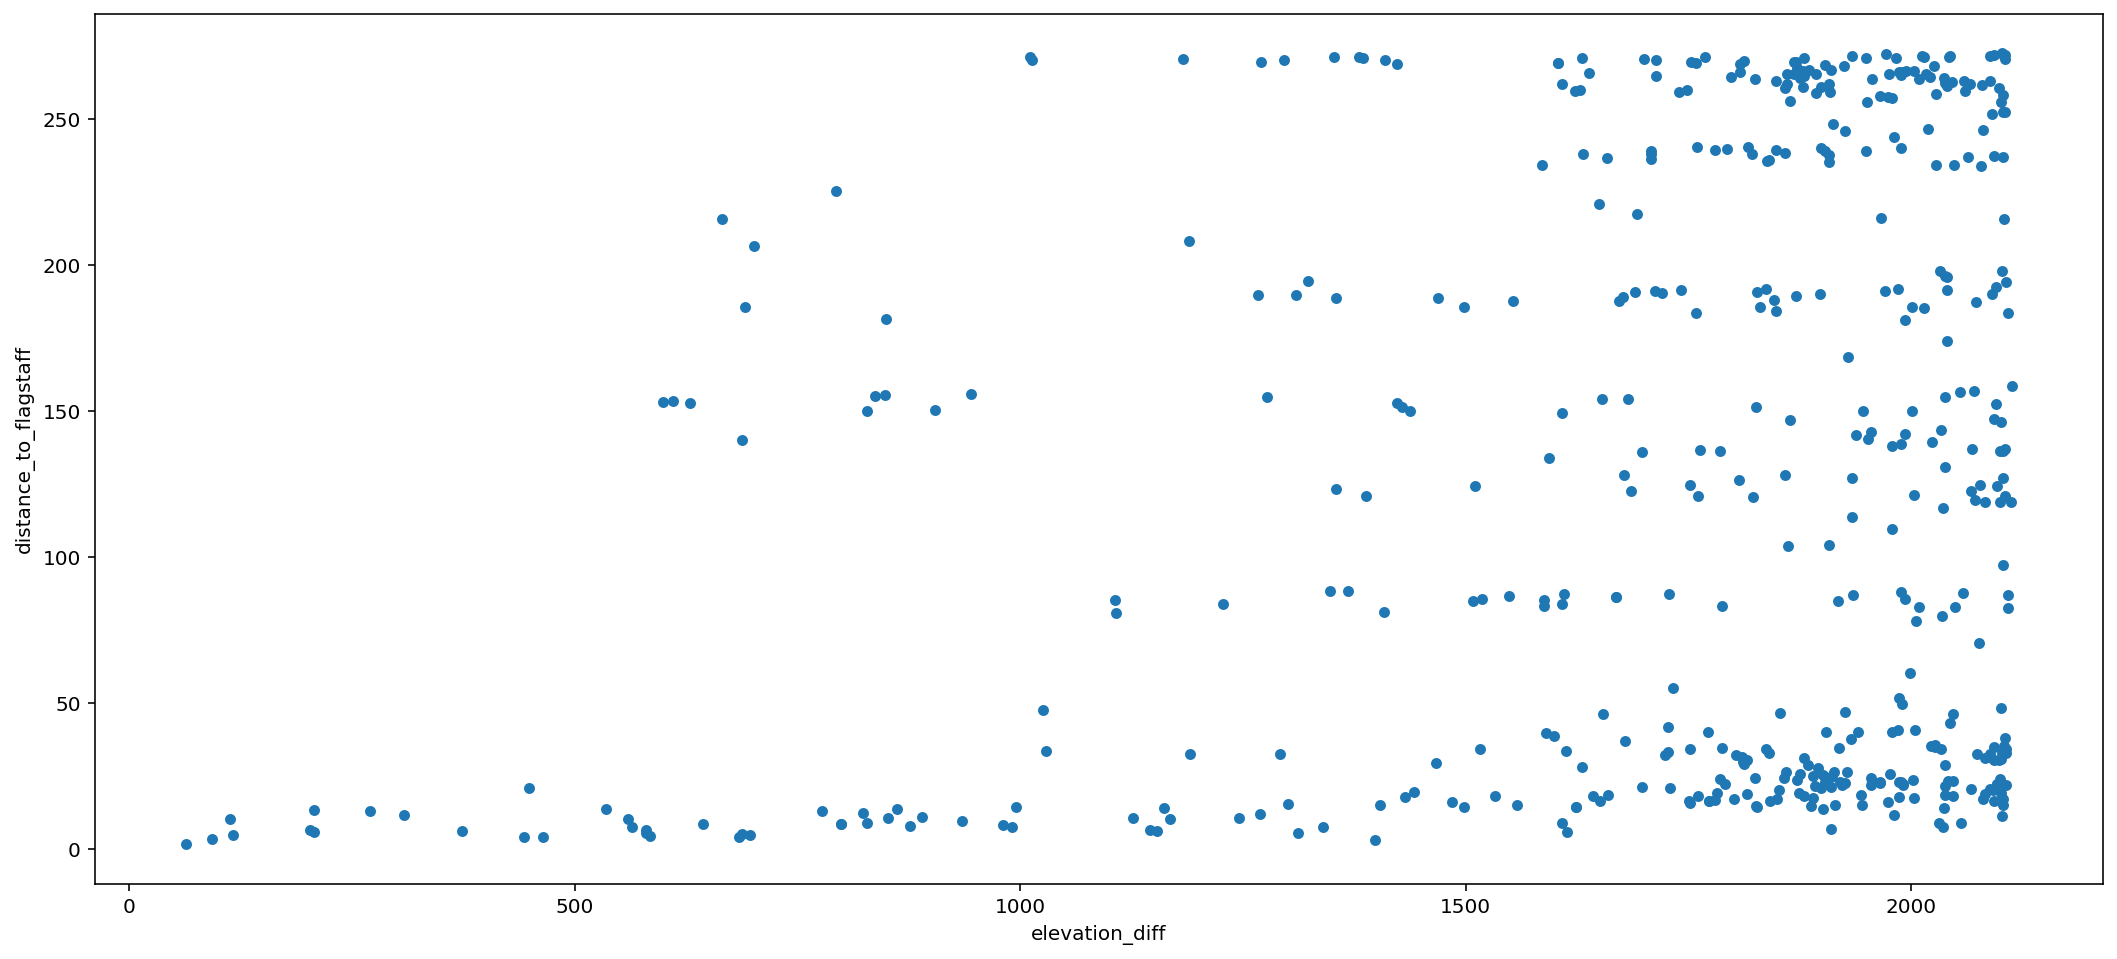

In [24]:

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('retina')
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
AxesSubplot_obj = climates_df.sample(500).plot(x='elevation_diff', y='distance_to_flagstaff', ax=ax, kind='scatter')

In [25]:

climates_df.is_like_flagstaff.value_counts()

False    1691111
True      821281
Name: is_like_flagstaff, dtype: int64

In [26]:

idx_list = climates_df[climates_df.is_like_flagstaff].index
idx_list

Int64Index([      5,       9,      15,      19,      26,      30,      42,
                 46,      51,      53,
            ...
            2512368, 2512370, 2512371, 2512379, 2512384, 2512385, 2512386,
            2512387, 2512388, 2512389],
           dtype='int64', length=821281)

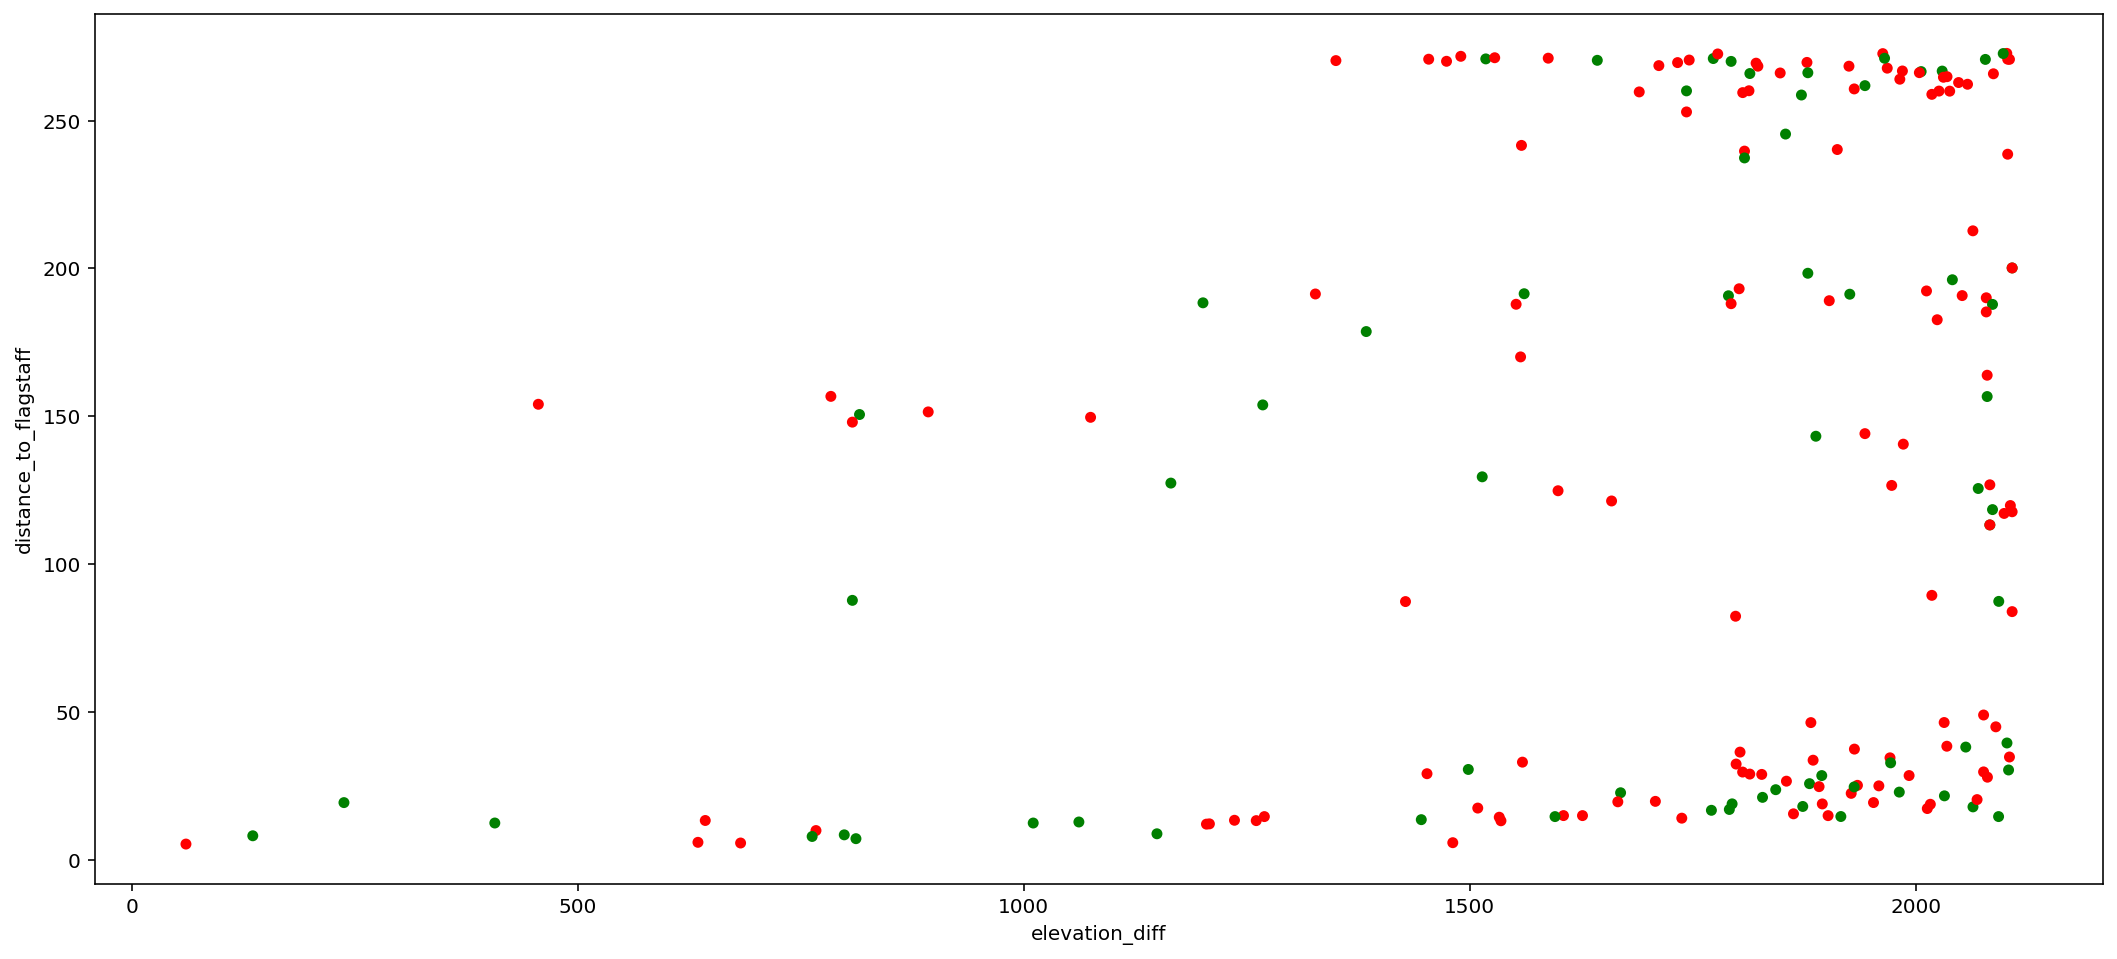

In [27]:

df = climates_df.sample(200)
colors_list = ['green' if x else 'red' for x in df.index.map(lambda x: x in idx_list)]
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111, autoscale_on=True)
path_collection = df.plot(x='elevation_diff', y='distance_to_flagstaff', ax=ax, kind='scatter', c=colors_list)

In [4]:

from sklearn import decomposition

[f'decomposition.{fn}' for fn in dir(decomposition) if not fn.startswith('_')]

['decomposition.DictionaryLearning', 'decomposition.FactorAnalysis', 'decomposition.FastICA', 'decomposition.IncrementalPCA', 'decomposition.KernelPCA', 'decomposition.LatentDirichletAllocation', 'decomposition.MiniBatchDictionaryLearning', 'decomposition.MiniBatchSparsePCA', 'decomposition.NMF', 'decomposition.PCA', 'decomposition.SparseCoder', 'decomposition.SparsePCA', 'decomposition.TruncatedSVD', 'decomposition.dict_learning', 'decomposition.dict_learning_online', 'decomposition.fastica', 'decomposition.non_negative_factorization', 'decomposition.randomized_svd', 'decomposition.sparse_encode']


----

In [13]:

file_path = '../data/html/world_city_populations.html'
world_city_populations_df = pd.read_html(file_path)[0]

In [14]:

world_city_populations_df

,Rank,Name,Country,2021 Population,2020 Population,Change
0,1,Tokyo,Japan,37339804,37393128,-0.14%
1,2,Delhi,India,31181376,30290936,2.94%
2,3,Shanghai,China,27795702,27058480,2.72%
3,4,Sao Paulo,Brazil,22237472,22043028,0.88%
4,5,Mexico City,Mexico,21918936,21782378,0.63%
...,...,...,...,...,...,...
1165,1166,Kolwezi,DR Congo,501375,494654,1.36%
1166,1167,Kabinda,DR Congo,501054,465599,7.61%
1167,1168,Jianyang,China,500925,487133,2.83%
1168,1169,Douai Lens,France,500921,500776,0.03%


In [7]:

import numpy as np

a = np.array(([0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0]))
ndimage.measurements.center_of_mass(a)

(2.0, 2.0)


----

In [16]:

%run ../load_magic/dataframes.py
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
url = 'https://en.wikipedia.org/wiki/Lists_of_cities_in_Europe'
dfs_list = get_page_tables(url, verbose=True)

[(2, (20, 2)), (5, (4, 2)), (7, (4, 2)), (6, (3, 2)), (8, (3, 2)), (9, (3, 2)), (10, (3, 2)), (3, (2, 2)), (0, (1, 2)), (1, (1, 2)), (4, (1, 2))]


In [19]:

%run ../load_magic/soup.py

page_soup = get_page_soup(url)
[f'page_soup.{fn}' for fn in dir(page_soup) if not fn.startswith('_')]

['page_soup.ASCII_SPACES', 'page_soup.DEFAULT_BUILDER_FEATURES', 'page_soup.NO_PARSER_SPECIFIED_WARNING', 'page_soup.ROOT_TAG_NAME', 'page_soup.append', 'page_soup.attrs', 'page_soup.builder', 'page_soup.can_be_empty_element', 'page_soup.cdata_list_attributes', 'page_soup.childGenerator', 'page_soup.children', 'page_soup.clear', 'page_soup.contains_replacement_characters', 'page_soup.contents', 'page_soup.currentTag', 'page_soup.current_data', 'page_soup.declared_html_encoding', 'page_soup.decode', 'page_soup.decode_contents', 'page_soup.decompose', 'page_soup.decomposed', 'page_soup.descendants', 'page_soup.element_classes', 'page_soup.encode', 'page_soup.encode_contents', 'page_soup.endData', 'page_soup.extend', 'page_soup.extract', 'page_soup.fetchNextSiblings', 'page_soup.fetchParents', 'page_soup.fetchPrevious', 'page_soup.fetchPreviousSiblings', 'page_soup.find', 'page_soup.findAll', 'page_soup.findAllNext', 'page_soup.findAllPrevious', 'page_soup.findChild', 'page_soup.findChild

In [27]:

[f'a_tag.{fn}' for fn in dir(a_tag) if not fn.startswith('_')]

['a_tag.append', 'a_tag.attrs', 'a_tag.can_be_empty_element', 'a_tag.cdata_list_attributes', 'a_tag.childGenerator', 'a_tag.children', 'a_tag.clear', 'a_tag.contents', 'a_tag.decode', 'a_tag.decode_contents', 'a_tag.decompose', 'a_tag.decomposed', 'a_tag.descendants', 'a_tag.encode', 'a_tag.encode_contents', 'a_tag.extend', 'a_tag.extract', 'a_tag.fetchNextSiblings', 'a_tag.fetchParents', 'a_tag.fetchPrevious', 'a_tag.fetchPreviousSiblings', 'a_tag.find', 'a_tag.findAll', 'a_tag.findAllNext', 'a_tag.findAllPrevious', 'a_tag.findChild', 'a_tag.findChildren', 'a_tag.findNext', 'a_tag.findNextSibling', 'a_tag.findNextSiblings', 'a_tag.findParent', 'a_tag.findParents', 'a_tag.findPrevious', 'a_tag.findPreviousSibling', 'a_tag.findPreviousSiblings', 'a_tag.find_all', 'a_tag.find_all_next', 'a_tag.find_all_previous', 'a_tag.find_next', 'a_tag.find_next_sibling', 'a_tag.find_next_siblings', 'a_tag.find_parent', 'a_tag.find_parents', 'a_tag.find_previous', 'a_tag.find_previous_sibling', 'a_tag

In [ ]:

from IPython.display import display, HTML

if 'title' in a_tag.attrs:
    title = a_tag.attrs['title']
    display(HTML(f'# <a href='https://en.wikipedia.org{href}'>{title}</a>'))

In [86]:

from urllib.parse import quote_plus

world_city_populations_df = pd.DataFrame([])
for a_tag in page_soup.findAll(name='a', attrs={'href': True}):
    href = a_tag.attrs['href'].split('#')[0]
    if href.startswith('/wiki/List_of_'):
        href = quote_plus(href.split('/')[-1])
        url = f'https://en.wikipedia.org/wiki/{href}'
        for df in get_page_tables(url, verbose=False):
            if any(map(lambda x: 'population' in str(x).lower(), df.columns)):
                world_city_populations_df = pd.concat([world_city_populations_df, df], ignore_index=True)
world_city_populations_df = world_city_populations_df.dropna(axis='columns', how='all')

In [101]:

columns_list = [cn for cn in world_city_populations_df.columns if 'population' in str(cn).lower()]
nan_threshold = len(columns_list) - 1
idx_list = []
for row_index, null_count in world_city_populations_df[columns_list].isnull().sum(axis='columns').iteritems():
    if null_count == nan_threshold:
        idx_list.append(row_index)
for row_index in idx_list:
    population = world_city_populations_df.loc[row_index, columns_list].dropna(axis='index', how='all').squeeze()
    world_city_populations_df.loc[row_index, columns_list] = np.nan
    world_city_populations_df.loc[row_index, 'Population'] = population
world_city_populations_df = world_city_populations_df.dropna(axis='columns', how='all')

In [102]:

columns_list = [cn for cn in world_city_populations_df.columns if 'population' in str(cn).lower()]
world_city_populations_df[columns_list].sample(20).dropna(axis='columns', how='all').T

C:\Users\dev\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,11594,6154,10591,1738,5748,2730,3113,3735,10353,5024,5776,3034,5020,3355,5979,9150,1636,5490,2496,241
"(.mw-parser-output .navbar{display:inline;font-size:88%;font-weight:normal}.mw-parser-output .navbar-collapse{float:left;text-align:left}.mw-parser-output .navbar-boxtext{word-spacing:0}.mw-parser-output .navbar ul{display:inline-block;white-space:nowrap;line-height:inherit}.mw-parser-output .navbar-brackets::before{margin-right:-0.125em;content:""[ ""}.mw-parser-output .navbar-brackets::after{margin-left:-0.125em;content:"" ]""}.mw-parser-output .navbar li{word-spacing:-0.125em}.mw-parser-output .navbar a>span,.mw-parser-output .navbar a>abbr{text-decoration:inherit}.mw-parser-output .navbar-mini abbr{font-variant:small-caps;border-bottom:none;text-decoration:none;cursor:inherit}.mw-parser-output .navbar-ct-full{font-size:114%;margin:0 7em}.mw-parser-output .navbar-ct-mini{font-size:114%;margin:0 4em}.mw-parser-output .infobox .navbar{font-size:100%}.mw-parser-output .navbox .navbar{display:block;font-size:100%}.mw-parser-output .navbox-title .navbar{float:left;text-align:left;margin-right:0.5em}vte Largest municipalities in CyprusCYstat – Population — Place of Residence, 2011 (Cyprus Census 2011) (sheet C1); DPÖ –Northern Cyprus 2011 Population and Housing Census, District)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nicosia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(.mw-parser-output .navbar{display:inline;font-size:88%;font-weight:normal}.mw-parser-output .navbar-collapse{float:left;text-align:left}.mw-parser-output .navbar-boxtext{word-spacing:0}.mw-parser-output .navbar ul{display:inline-block;white-space:nowrap;line-height:inherit}.mw-parser-output .navbar-brackets::before{margin-right:-0.125em;content:""[ ""}.mw-parser-output .navbar-brackets::after{margin-left:-0.125em;content:"" ]""}.mw-parser-output .navbar li{word-spacing:-0.125em}.mw-parser-output .navbar a>span,.mw-parser-output .navbar a>abbr{text-decoration:inherit}.mw-parser-output .navbar-mini abbr{font-variant:small-caps;border-bottom:none;text-decoration:none;cursor:inherit}.mw-parser-output .navbar-ct-full{font-size:114%;margin:0 7em}.mw-parser-output .navbar-ct-mini{font-size:114%;margin:0 4em}.mw-parser-output .infobox .navbar{font-size:100%}.mw-parser-output .navbox .navbar{display:block;font-size:100%}.mw-parser-output .navbox-title .navbar{float:left;text-align:left;margin-right:0.5em}vte Largest municipalities in CyprusCYstat – Population — Place of Residence, 2011 (Cyprus Census 2011) (sheet C1); DPÖ –Northern Cyprus 2011 Population and Housing Census, Name)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Strovolos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(.mw-parser-output .navbar{display:inline;font-size:88%;font-weight:normal}.mw-parser-output .navbar-collapse{float:left;text-align:left}.mw-parser-output .navbar-boxtext{word-spacing:0}.mw-parser-output .navbar ul{display:inline-block;white-space:nowrap;line-height:inherit}.mw-parser-output .navbar-brackets::before{margin-right:-0.125em;content:""[ ""}.mw-parser-output .navbar-brackets::after{margin-left:-0.125em;content:"" ]""}.mw-parser-output .navbar li{word-spacing:-0.125em}.mw-parser-output .navbar a>span,.mw-parser-output .navbar a>abbr{text-decoration:inherit}.mw-parser-output .navbar-mini abbr{font-variant:small-caps;border-bottom:none;text-decoration:none;cursor:inherit}.mw-parser-output .navbar-ct-full{font-size:114%;margin:0 7em}.mw-parser-output .navbar-ct-mini{font-size:114%;margin:0 4em}.mw-parser-output .infobox .navbar{font-size:100%}.mw-parser-output .navbox .navbar{display:block;font-size:100%}.mw-parser-output .navbox-title .navbar{float:left;text-align:left;margin-right:0.5em}vte Largest municipalities in CyprusCYstat – Population — Place of Residence, 2011 (Cyprus Census 2011) (sheet C1); DPÖ –Northern Cyprus 2011 Population and Housing Census, Pop.)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(.mw-parser-output .navbar{display:inline;font-size:88%;fon

In [130]:

population_columns_list = [cn for cn in world_city_populations_df.columns if 'population' in str(cn).lower()]
column_descriptions_df = get_column_descriptions(world_city_populations_df, population_columns_list)
print(column_descriptions_df.sort_values('count_blanks', ascending=True).head(20).column_name.tolist())
column_descriptions_df.sort_values('count_blanks', ascending=True).head(20)

['Population', 'Population, 2013', 'Population, 2006', 'Population, 2017', 'Population (2002)', 'Population (2011)[2]', 'Population 2001\xa0census', 'Population 1992\xa0census', 'Population 2011\xa0census[1][4]', 'Population 1946[2][3]', 'Population (2021 estimate)[1]', 'Population (2001 Census)', 'Population change', ('Population', 'Agglomeration (2015)[5]'), ('Population', 'Town proper (2020) [4]'), ('Population', '2001'), ('Population', '2019'), ('Population', 'Change'), 'Population2012 Estimate[6]', 'Population2009 Census[7]']


,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates,min_value,max_value,only_integers
59,Population,object,4546,3569,2,True,NaN,NaN,NaN
26,"Population, 2013",float64,11215,459,0,True,14223.0,2229621.0,False
56,"Population, 2006",object,11215,454,0,True,101587,99291,NaN
27,"Population, 2017",float64,11215,457,0,True,20033.0,2187526.0,False
4,Population (2002),float64,11497,321,0,True,1802.0,1926334.0,False
6,Population (2011)[2],float64,11497,320,0,True,1641.0,1883425.0,False
54,Population 2001 census,object,11621,252,0,True,-,9954,NaN
53,Population 1992 census,object,11621,146,0,True,-,9969,NaN
17,Population 2011 census[1][4],float64,11621,255,0,True,347.0,7364570.0,False
52,Population 1946[2][3],object,11621,96,0,True,-,9929,NaN


In [129]:

columns_list = [cn for cn in world_city_populations_df.columns if (cn not in population_columns_list)]
column_descriptions_df = get_column_descriptions(world_city_populations_df, columns_list)
print(column_descriptions_df.sort_values('count_blanks', ascending=True).head(20).column_name.tolist())
column_descriptions_df.sort_values('count_blanks', ascending=True).head(20)

['City name', 'Designation', 'Rank', 'County', 'Region', 'Department', 'Rank 2017', 'City name (in Ukrainian)', 'Subdivision', ('District', 'District'), 'Municipality', 'Year statusgranted (a) orfirst attested (b)', ('Town', 'Town'), ('Town\xa0(h) or market\xa0(m) right, founding date & reference', 'Town\xa0(h) or market\xa0(m) right, founding date & reference'), 'Province (Oblast)', ('Canton', 'Canton'), ('Agglomeration[3]', 'Agglomeration[3]'), 'Altitude (m)', 'In Armenian', 'In Azerbaijani']


,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates,min_value,max_value,only_integers
48,City name,object,1896,5359,0,False,A Coruña,Țăndărei,NaN
70,Designation,object,7943,5,0,False,Market town,Statutory city,NaN
114,Rank,object,10787,289,0,True,NaN,NaN,NaN
55,County,object,11048,77,0,False,Agder,—,NaN
118,Region,object,11179,23,0,False,Auvergne-Rhône-Alpes,Île-de-France,NaN
68,Department,object,11201,95,0,False,Ain,Yvelines,NaN
9,Rank 2017,float64,11201,469,0,True,1.0,468.0,False
47,City name (in Ukrainian),object,11213,460,0,False,Євпаторія,Ясинувата,NaN
126,Subdivision,object,11213,28,0,False,Cherkasy Oblast,Zhytomyr Oblast,NaN
76,"(District, District)",object,11339,195,0,False,Aarau,–,NaN


In [113]:

name_columns_list = ['Name', 'City', 'Commune', 'City name', 'Municipality', 'City/town/village', ('Town', 'Town'), ('District', 'District'), 'City[1]', ('City or town', 'City or town')]
nan_threshold = len(name_columns_list) - 1
idx_list = []
for row_index, null_count in world_city_populations_df[name_columns_list].isnull().sum(axis='columns').iteritems():
    if null_count == nan_threshold:
        idx_list.append(row_index)
for row_index in idx_list:
    city_name = world_city_populations_df.loc[row_index, name_columns_list].dropna(axis='index', how='all').squeeze()
    world_city_populations_df.loc[row_index, name_columns_list] = np.nan
    world_city_populations_df.loc[row_index, 'City name'] = city_name
world_city_populations_df = world_city_populations_df.dropna(axis='columns', how='all')

C:\Users\dev\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [123]:

for column_name in [('City or town', 'City or town'), ('Town', 'Town'), 'City', 'City[1]']:
    if column_name in world_city_populations_df.columns:
        mask_series = world_city_populations_df['City name'].isnull() & ~world_city_populations_df[column_name].isnull()
        for row_index, row_series in world_city_populations_df[mask_series].iterrows():
            city_name = row_series[column_name]
            world_city_populations_df.loc[row_index, 'City name'] = city_name
            world_city_populations_df.loc[row_index, column_name] = np.nan
        world_city_populations_df = world_city_populations_df.dropna(axis='columns', how='all')

In [125]:

name_columns_list = ['Name', 'City', 'Commune', 'City name', 'Municipality', 'City/town/village', ('Town', 'Town'), ('District', 'District'), 'City[1]', ('City or town', 'City or town')]
name_columns_list = [cn for cn in world_city_populations_df.columns if (cn in name_columns_list)]
print(name_columns_list)
world_city_populations_df[name_columns_list].sample(20).dropna(axis='columns', how='all').T

['City name', ('City or town', 'City or town'), ('District', 'District'), 'Municipality', ('Town', 'Town')]


C:\Users\dev\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,3355,5096,7556,10034,7687,5198,7596,9842,9885,328,9124,9691,11814,629,1670,3239,3230,11670,3476,4981
City name,Mantes-la-Jolie,Fribourg,Dechantskirchen,NaN,Niklasdorf,Rheinau,Gratkorn,NaN,NaN,Vau i Dejës,Chernomorets,Les Pavillons-sous-Bois,Skhtorashen,Gallizien,Strallegg,Tourcoing,Besançon,Dedoplistsqaro,Bezons,Spišská Stará Ves
"(City or town, City or town)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spišská Stará Ves
"(District, District)",NaN,Sarine,NaN,NaN,NaN,Andelfingen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kežmarok
Municipality,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vau i Dejës,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(Town, Town)",NaN,Fribourg,NaN,NaN,NaN,Rheinau,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:

columns_list = ['City name', 'Population']
mask_series = ~world_city_populations_df['City name'].isnull() & ~world_city_populations_df['Population'].isnull()
print(world_city_populations_df[columns_list][mask_series].shape)
world_city_populations_df[columns_list][mask_series].sample(20).T

(6620, 2)


,5568,5544,11746,931,7144,5624,8519,7262,5676,8274,11596,10110,462,1003,646,1988,8056,1822,4269,10233
City name,Sudak,Tulchyn,Sus,Höflein an der Hohen Wand,Matzen-Raggendorf,Khrystynivka,Weißenkirchen im Attergau,Schottwien,Chop,Linz,Leeds1,Sandnes,Hackerberg,Leopoldsdorf im Marchfelde,Hüttenberg,Aichkirchen,Tarrenz,Kufstein,Ringerike,Felgueiras
Population,14495.0,16136.0,26,895,2794,11650.0,964,660,8919.0,204846,"751,485 (2011)[20]",78624,357,2848,1414,582,2744,19223,13930,15100.0


In [4]:

from scipy import ndimage

ndimage.map_coordinates?

Signature:
ndimage.map_coordinates(
    input,
    coordinates,
    output=None,
    order=3,
    mode='constant',
    cval=0.0,
    prefilter=True,
)
Docstring:
Map the input array to new coordinates by interpolation.

The array of coordinates is used to find, for each point in the output,
the corresponding coordinates in the input. The value of the input at
those coordinates is determined by spline interpolation of the
requested order.

The shape of the output is derived from that of the coordinate
array by dropping the first axis. The values of the array along
the first axis are the coordinates in the input array at which the
output value is found.

Parameters
----------
input : array_like
    The input array.
coordinates : array_like
    The coordinates at which `input` is evaluated.
output : array or dtype, optional
    The array in which to place the output, or the dtype of the
    returned array. By default an array of the same dtype as input
    will be created.
order : int, op


----

In [29]:

mask_series = climates_df.NAME.map(lambda x: 'flagstaff' in x.lower())
df = climates_df[mask_series]
dist_min = df.distance_to_flagstaff.min()
columns_list = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'distance_to_flagstaff']
df[columns_list].sample(12).sort_values('distance_to_flagstaff', ascending=False).T

,44,10,8,16,1,6,17,23,6,23,1,3
STATION,SF001538750,SF001538750,USR0000OFLA,USR0000OFLA,US1AZCN0002,US1AZCN0021,USC00023009,USR0000AFLG,USR0000AFLG,USW00003103,USC00023011,US1AZCN0033
NAME,"FLAGSTAFF TNK, SF","FLAGSTAFF TNK, SF","FLAGSTAFF HILL OREGON, OR US","FLAGSTAFF HILL OREGON, OR US","FLAGSTAFF 7.8 SSW, AZ US","FLAGSTAFF 6.8 NW, AZ US","FLAGSTAFF 4 SW, AZ US","FLAGSTAFF ARIZONA, AZ US","FLAGSTAFF ARIZONA, AZ US","FLAGSTAFF AIRPORT, AZ US","FLAGSTAFF A, AZ US","FLAGSTAFF 2.2 SW, AZ US"
LATITUDE,-31.08,-31.08,44.8142,44.8142,35.09385,35.25598,35.1611,35.145,35.145,35.1441,35.2,35.17041
LONGITUDE,29.5,29.5,-117.7289,-117.7289,-111.69535,-111.740379,-111.7311,-111.675,-111.675,-111.6663,-111.6,-111.681546
ELEVATION,838.0,838.0,1202.4,1202.4,2078.7,2231.1,2171.7,2133.6,2133.6,2134.5,NaN,2146.7
distance_to_flagstaff,155.937488,155.937488,11.375547,11.375547,0.113344,0.106132,0.088039,0.058317,0.058317,0.056222,0.051328,0.041132


In [30]:

mask_series = (climates_df.distance_to_flagstaff < 0.2)
df = climates_df[mask_series]
columns_list = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'distance_to_flagstaff']
df[columns_list].sample(12).sort_values('distance_to_flagstaff', ascending=False).T

,21,9,37,14,92,87,2,6,22,5,51,54
STATION,USC00020678,USC00029156,USC00029156,USC00029156,USC00023160,USC00023160,USS0011P02S,USC00023009,USC00023009,USR0000AFLG,USW00003103,USW00003103
NAME,"BELLEMONT WEATHER FORECAST OFFICE, AZ US","WALNUT CANYON N.M., AZ US","WALNUT CANYON N.M., AZ US","WALNUT CANYON N.M., AZ US","FORT VALLEY, AZ US","FORT VALLEY, AZ US","FORT VALLEY, AZ US","FLAGSTAFF 4 SW, AZ US","FLAGSTAFF 4 SW, AZ US","FLAGSTAFF ARIZONA, AZ US","FLAGSTAFF AIRPORT, AZ US","FLAGSTAFF AIRPORT, AZ US"
LATITUDE,35.2302,35.1721,35.1721,35.1721,35.2681,35.2681,35.27,35.1611,35.1611,35.145,35.1441,35.1441
LONGITUDE,-111.8221,-111.5097,-111.5097,-111.5097,-111.7428,-111.7428,-111.74,-111.7311,-111.7311,-111.675,-111.6663,-111.6663
ELEVATION,2179.9,2040.6,2040.6,2040.6,2239.4,2239.4,2240.3,2171.7,2171.7,2133.6,2134.5,2134.5
distance_to_flagstaff,0.173757,0.144,0.144,0.144,0.115094,0.115094,0.114066,0.088039,0.088039,0.058317,0.056222,0.056222


In [35]:

# Flagstaff is 2108 meters with elevation that is 1829 meters higher than average city elevation in United States.
# Scale of surrounding elevation is from 2068 to 2472 m with average elevation of 2150.3 meters.
climates_df['elevation_diff'] = climates_df.ELEVATION.map(lambda x: abs(x - 2108))
s.store_objects(climates_df=climates_df)

Pickling to D:\Documents\GitHub\notebooks\saves\pickle\climates_df.pickle



----

In [29]:

%run ../load_magic/dataframes.py

column_descriptions_df = get_column_descriptions(climates_df.sample(5_000))
column_descriptions_df['dtype'].unique()

array(['int64', 'float64', 'object'], dtype=object)

In [30]:

numeric_match_series = column_descriptions_df['dtype'].isin(['int64', 'float64'])
column_descriptions_df[~numeric_match_series]['column_name'].tolist()

['STATION', 'NAME', 'DP01_ATTRIBUTES', 'DP10_ATTRIBUTES', 'DP1X_ATTRIBUTES', 'DSNW_ATTRIBUTES', 'DYTS_ATTRIBUTES', 'EMSD_ATTRIBUTES', 'EMSN_ATTRIBUTES', 'EMXP_ATTRIBUTES', 'PRCP_ATTRIBUTES', 'SNOW_ATTRIBUTES', 'CLDD_ATTRIBUTES', 'DT00_ATTRIBUTES', 'DT32_ATTRIBUTES', 'DX32_ATTRIBUTES', 'DX70_ATTRIBUTES', 'DX90_ATTRIBUTES', 'EMNT_ATTRIBUTES', 'EMXT_ATTRIBUTES', 'HTDD_ATTRIBUTES', 'TAVG_ATTRIBUTES', 'TMAX_ATTRIBUTES', 'TMIN_ATTRIBUTES', 'FZF0_ATTRIBUTES', 'FZF1_ATTRIBUTES', 'FZF5_ATTRIBUTES', 'FZF6_ATTRIBUTES', 'FZF2_ATTRIBUTES', 'FZF7_ATTRIBUTES', 'FZF8_ATTRIBUTES', 'FZF9_ATTRIBUTES', 'FZF3_ATTRIBUTES', 'FZF4_ATTRIBUTES', 'DYFG_ATTRIBUTES', 'AWND_ATTRIBUTES', 'MNPN_ATTRIBUTES', 'MXPN_ATTRIBUTES', 'PSUN_ATTRIBUTES', 'TSUN_ATTRIBUTES', 'WDF1_ATTRIBUTES', 'WDF2_ATTRIBUTES', 'WDF5_ATTRIBUTES', 'WDFG_ATTRIBUTES', 'WDFM_ATTRIBUTES', 'WDMV_ATTRIBUTES', 'WSF1_ATTRIBUTES', 'WSF2_ATTRIBUTES', 'WSF5_ATTRIBUTES', 'WSFG_ATTRIBUTES', 'WSFM_ATTRIBUTES', 'DYHF_ATTRIBUTES', 'EVAP_ATTRIBUTES', 'HN01_ATTRI

In [31]:

column_descriptions_df[numeric_match_series]['column_name'].tolist()

['index', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DP01', 'DP10', 'DP1X', 'DSND', 'DSND_ATTRIBUTES', 'DSNW', 'DYTS', 'EMSD', 'EMSN', 'EMXP', 'PRCP', 'SNOW', 'CDSD', 'CDSD_ATTRIBUTES', 'CLDD', 'DT00', 'DT32', 'DX32', 'DX70', 'DX90', 'EMNT', 'EMXT', 'HDSD', 'HDSD_ATTRIBUTES', 'HTDD', 'TAVG', 'TMAX', 'TMIN', 'FZF0', 'FZF1', 'FZF5', 'FZF6', 'FZF2', 'FZF7', 'FZF8', 'FZF9', 'FZF3', 'FZF4', 'DYFG', 'AWND', 'MNPN', 'MXPN', 'PSUN', 'TSUN', 'WDF1', 'WDF2', 'WDF5', 'WDFG', 'WDFM', 'WDMV', 'WSF1', 'WSF2', 'WSF5', 'WSFG', 'WSFM', 'DYHF', 'EVAP', 'HN01', 'HN02', 'HN03', 'HX01', 'HX02', 'HX03', 'LN01', 'LN02', 'LN03', 'LX01', 'LX02', 'LX03', 'MN01', 'MN02', 'MN03', 'MX01', 'MX02', 'MX03', 'HN04', 'HN05', 'HX04', 'HX05', 'LN04', 'LN05', 'LX04', 'LX05', 'MN04', 'MN05', 'MX04', 'MX05', 'HN06', 'HN07', 'HN08', 'HX06', 'HX07', 'HX08', 'LN06', 'LN07', 'LN08', 'LX06', 'LX07', 'LX08', 'MN06', 'MN07', 'MN08', 'MX06', 'MX07', 'MX08', 'HN09', 'LN09', 'MN09', 'distance_to_flagstaff', 'elevation_diff']

In [32]:

df = column_descriptions_df[numeric_match_series].sort_values('count_blanks').head(20)
print(df.column_name.tolist())
df

['index', 'DATE', 'LATITUDE', 'LONGITUDE', 'distance_to_flagstaff', 'elevation_diff', 'ELEVATION', 'PRCP', 'DP10', 'DP1X', 'DP01', 'EMXP', 'TMAX', 'EMXT', 'DX70', 'DX32', 'DX90', 'TMIN', 'EMNT', 'DT00']


,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates,min_value,max_value,only_integers
0,index,int64,0,128,170,True,0,154,True
1,DATE,int64,0,147,0,True,1861,2021,True
2,LATITUDE,float64,0,4360,0,True,-51.617,79.9833,False
3,LONGITUDE,float64,0,4490,0,True,-178.9,172.532,False
113,distance_to_flagstaff,float64,0,4761,0,True,0.048086,294.875967,False
114,elevation_diff,float64,128,2052,0,True,0.3,2925.0,False
4,ELEVATION,float64,128,2062,22,True,-25.0,5033.0,False
15,PRCP,float64,487,3905,3,True,0.0,5836.0,False
6,DP10,float64,613,175,4,True,0.0,227.0,False
7,DP1X,float64,613,61,456,True,0.0,78.0,False


In [42]:

from sklearn.decomposition import PCA

mask_series = (climates_df.distance_to_flagstaff < 0.2)
idx_list = climates_df[mask_series].index.tolist()
mask_series = index_df.index.map(lambda x: x in idx_list)
pca_ndarray = PCA(n_components=2).fit_transform(X)

In [44]:

colors_list = ['green' if x else 'red' for x in mask_series]

In [36]:

x_array = [[24.0, 543.2, 88.0, 44.0, 3.0, 42.4, 11.22, 3.0, 0.0, -0.9, 22.76, 20.0, 212.0, 0.0, 42.4, 16.99]]
clf.predict(X)[0]

True

In [37]:

index_df.is_like_flagstaff.all(), all(y)

(False, False)

In [38]:

idx_list = index_df[index_df.is_like_flagstaff].index
climates_df['is_like_flagstaff'] = climates_df.index.map(lambda x: x in idx_list)
s.store_objects(climates_df=climates_df)

Pickling to D:\Documents\GitHub\notebooks\saves\pickle\climates_df.pickle


In [90]:

mask_series = climates_df.NAME.map(lambda x: 'flagstaff' in x.lower())
df = climates_df[mask_series]
columns_list = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'elevation_diff', 'distance_to_flagstaff', 'is_like_flagstaff']
df[columns_list].sample(12).sort_values('distance_to_flagstaff', ascending=False).T

,68,47,2,24,0,15,3,64,1,78,9,1
STATION,SF001538750,SF001538750,USC00172805,USC00023009,USR0000AFLG,USR0000AFLG,USW00003103,USW00003103,USW00003103,USW00003103,USW00003103,USC00023011
NAME,"FLAGSTAFF TNK, SF","FLAGSTAFF TNK, SF","FLAGSTAFF, ME US","FLAGSTAFF 4 SW, AZ US","FLAGSTAFF ARIZONA, AZ US","FLAGSTAFF ARIZONA, AZ US","FLAGSTAFF AIRPORT, AZ US","FLAGSTAFF AIRPORT, AZ US","FLAGSTAFF AIRPORT, AZ US","FLAGSTAFF AIRPORT, AZ US","FLAGSTAFF AIRPORT, AZ US","FLAGSTAFF A, AZ US"
LATITUDE,-31.08,-31.08,45.216667,35.1611,35.145,35.145,35.1441,35.1441,35.1441,35.1441,35.1441,35.2
LONGITUDE,29.5,29.5,-70.2,-111.7311,-111.675,-111.675,-111.6663,-111.6663,-111.6663,-111.6663,-111.6663,-111.6
ELEVATION,838.0,838.0,NaN,2171.7,2133.6,2133.6,2134.5,2134.5,2134.5,2134.5,2134.5,NaN
elevation_diff,1270.0,1270.0,NaN,63.7,25.6,25.6,26.5,26.5,26.5,26.5,26.5,NaN
distance_to_flagstaff,155.937488,155.937488,42.644791,0.088039,0.058317,0.058317,0.056222,0.056222,0.056222,0.056222,0.056222,0.051328
is_like_flagstaff,False,True,False,False,False,False,False,True,False,True,True,False


In [91]:

mask_series = climates_df.is_like_flagstaff
df = climates_df[mask_series]
columns_list = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'elevation_diff', 'distance_to_flagstaff', 'is_like_flagstaff']
df[columns_list].sort_values('distance_to_flagstaff').tail(12).T

,34,33,32,30,9,17,16,14,31,25,5,9
STATION,AYM00089664,AYM00089664,AYM00089664,AYM00089664,AYM00089664,AYM00089664,AYM00089664,AYM00089664,AYM00089664,AYM00089664,AYW00087701,AYW00087701
NAME,"MCMURDO SOUND NAF, AY","MCMURDO SOUND NAF, AY","MCMURDO SOUND NAF, AY","MCMURDO SOUND NAF, AY","MCMURDO SOUND NAF, AY","MCMURDO SOUND NAF, AY","MCMURDO SOUND NAF, AY","MCMURDO SOUND NAF, AY","MCMURDO SOUND NAF, AY","MCMURDO SOUND NAF, AY","ADARE HALLETT, AY","ADARE HALLETT, AY"
LATITUDE,-77.8833,-77.8833,-77.8833,-77.8833,-77.8833,-77.8833,-77.8833,-77.8833,-77.8833,-77.8833,-72.29444,-72.29444
LONGITUDE,166.7333,166.7333,166.7333,166.7333,166.7333,166.7333,166.7333,166.7333,166.7333,166.7333,170.30833,170.30833
ELEVATION,24.1,24.1,24.1,24.1,24.1,24.1,24.1,24.1,24.1,24.1,5.2,5.2
elevation_diff,2083.9,2083.9,2083.9,2083.9,2083.9,2083.9,2083.9,2083.9,2083.9,2083.9,2102.8,2102.8
distance_to_flagstaff,300.475339,300.475339,300.475339,300.475339,300.475339,300.475339,300.475339,300.475339,300.475339,300.475339,301.754732,301.754732
is_like_flagstaff,True,True,True,True,True,True,True,True,True,True,True,True


In [94]:

mask_series = climates_df.is_like_flagstaff
df = climates_df[mask_series]
columns_list = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'elevation_diff', 'distance_to_flagstaff', 'is_like_flagstaff']
df[columns_list].sort_values('elevation_diff').head(12).T

,5,5,5,9,14,16,17,14,9,16,5,32
STATION,MXN00032002,MXN00032009,MXN00021163,MXN00021163,MXN00021163,MXN00021163,MXN00032002,MXN00032002,MXN00032002,MXN00032002,USR0000CBIP,USS0017H02S
NAME,"BOCA DEL TESORERO, MX","JEREZ DE GARCIA SALINAS SMN, MX","EL BATAN, MX","EL BATAN, MX","EL BATAN, MX","EL BATAN, MX","BOCA DEL TESORERO, MX","BOCA DEL TESORERO, MX","BOCA DEL TESORERO, MX","BOCA DEL TESORERO, MX","BIG PINES CALIFORNIA, CA US","BUCKSKIN LOWER, NV US"
LATITUDE,22.8167,22.65,18.9667,18.9667,18.9667,18.9667,22.8167,22.8167,22.8167,22.8167,34.3789,41.75
LONGITUDE,-102.95,-103.0,-98.1667,-98.1667,-98.1667,-98.1667,-102.95,-102.95,-102.95,-102.95,-117.6919,-117.53
ELEVATION,2108.0,2108.0,2108.0,2108.0,2108.0,2108.0,2108.0,2108.0,2108.0,2108.0,2108.3,2107.7
elevation_diff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.3
distance_to_flagstaff,15.133282,15.241536,21.102102,21.102102,21.102102,21.102102,15.133282,15.133282,15.133282,15.133282,6.095921,8.802506
is_like_flagstaff,True,True,True,True,True,True,True,True,True,True,True,True


In [ ]:

mask_series = climates_df.is_like_flagstaff
df = climates_df[mask_series]
df.NAME.unique().tolist()

In [96]:

mask_series = climates_df.is_like_flagstaff
columns_list = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'elevation_diff', 'distance_to_flagstaff', 'is_like_flagstaff']
df = climates_df[mask_series][columns_list]
df.sort_values(['elevation_diff', 'distance_to_flagstaff'], ascending=[True, False]).head(12).T

,5,9,14,16,5,5,9,14,16,17,5,9
STATION,MXN00021163,MXN00021163,MXN00021163,MXN00021163,MXN00032009,MXN00032002,MXN00032002,MXN00032002,MXN00032002,MXN00032002,USS0017H02S,USS0017H02S
NAME,"EL BATAN, MX","EL BATAN, MX","EL BATAN, MX","EL BATAN, MX","JEREZ DE GARCIA SALINAS SMN, MX","BOCA DEL TESORERO, MX","BOCA DEL TESORERO, MX","BOCA DEL TESORERO, MX","BOCA DEL TESORERO, MX","BOCA DEL TESORERO, MX","BUCKSKIN LOWER, NV US","BUCKSKIN LOWER, NV US"
LATITUDE,18.9667,18.9667,18.9667,18.9667,22.65,22.8167,22.8167,22.8167,22.8167,22.8167,41.75,41.75
LONGITUDE,-98.1667,-98.1667,-98.1667,-98.1667,-103.0,-102.95,-102.95,-102.95,-102.95,-102.95,-117.53,-117.53
ELEVATION,2108.0,2108.0,2108.0,2108.0,2108.0,2108.0,2108.0,2108.0,2108.0,2108.0,2107.7,2107.7
elevation_diff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.3
distance_to_flagstaff,21.102102,21.102102,21.102102,21.102102,15.241536,15.133282,15.133282,15.133282,15.133282,15.133282,8.802506,8.802506
is_like_flagstaff,True,True,True,True,True,True,True,True,True,True,True,True


In [101]:

df = df[columns_list]
# df.melt(id_vars=['NAME'], value_vars=['elevation_diff', 'distance_to_flagstaff', 'is_like_flagstaff'], var_name=None, value_name='value', col_level=None, ignore_index=True)
df.groupby('elevation_diff').distance_to_flagstaff.max().head(20)

elevation_diff
0.0    21.102102
0.3     8.802506
0.9    19.623067
1.2    18.633362
1.8    16.746147
2.1    16.077287
2.4     7.942295
2.7    21.477546
3.1    17.493024
4.0    19.979073
4.3    46.848962
4.9    26.542465
5.2    16.426187
5.8    18.139283
6.1    10.334515
6.4     6.713603
6.7    22.916781
7.0    23.016230
7.3     7.769013
7.6     5.762366
Name: distance_to_flagstaff, dtype: float64

In [110]:

# Flagstaff, AZ, USA
# Latitude and longitude coordinates are: 35.198284, -111.651299
import wikipedia

print([f'wikipedia.{fn}' for fn in dir(wikipedia) if not fn.startswith('_')])
flagstaff_latitude = 35.198284
flagstaff_longitude = -111.651299
wikipedia.geosearch(latitude=flagstaff_latitude, longitude=flagstaff_longitude)

['wikipedia.API_URL', 'wikipedia.BeautifulSoup', 'wikipedia.Decimal', 'wikipedia.DisambiguationError', 'wikipedia.HTTPTimeoutError', 'wikipedia.ODD_ERROR_MESSAGE', 'wikipedia.PageError', 'wikipedia.RATE_LIMIT', 'wikipedia.RATE_LIMIT_LAST_CALL', 'wikipedia.RATE_LIMIT_MIN_WAIT', 'wikipedia.RedirectError', 'wikipedia.USER_AGENT', 'wikipedia.WikipediaException', 'wikipedia.WikipediaPage', 'wikipedia.cache', 'wikipedia.datetime', 'wikipedia.debug', 'wikipedia.donate', 'wikipedia.exceptions', 'wikipedia.geosearch', 'wikipedia.languages', 'wikipedia.page', 'wikipedia.random', 'wikipedia.re', 'wikipedia.requests', 'wikipedia.search', 'wikipedia.set_lang', 'wikipedia.set_rate_limiting', 'wikipedia.set_user_agent', 'wikipedia.stdout_encode', 'wikipedia.suggest', 'wikipedia.summary', 'wikipedia.sys', 'wikipedia.time', 'wikipedia.timedelta', 'wikipedia.unicode_literals', 'wikipedia.util', 'wikipedia.wikipedia']


['Orpheum Theater (Flagstaff, Arizona)', 'Flagstaff station', 'Weatherford Hotel', 'First Baptist Church (Flagstaff, Arizona)', 'Our Lady of Guadaloupe Church', 'Hotel Monte Vista', 'Downtown Flagstaff, Arizona', 'Presbyterian Church Parsonage (Flagstaff, Arizona)', 'Brannen-Devine House', 'Flagstaff High School']

In [ ]:

print([f'WikipediaPage_obj.{fn}' for fn in dir(WikipediaPage_obj) if not fn.startswith('_')])

In [5]:

import random

os.makedirs(name=s.data_csv_folder, exist_ok=True)
file_name = random.choice(csvs_list)